This script requires all prediction inspector csvs for the corresponding target.
They are generated using the `predict_cognition.submit` script.

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl

In [2]:
# Set global variables (these can be adjusted according to file location and which results should be plotted)
RESULT_ROOT = "/Users/amelie/Datasets/clinical_dmri_benchmark/prediction_results/remove_confounds_features"
TARGET = "cpxresAZv2"
TBV_AS_CONFOUND = False
SAVE_ROOT = "../../figures/prediction"
os.makedirs(SAVE_ROOT, exist_ok=True)

if TBV_AS_CONFOUND == True:
    RESULT_ROOT = RESULT_ROOT + "/include_TBV"
    SAVE_NAME = f"prediction_reliability_{TARGET}_includeTBV.svg"
else:
    SAVE_NAME = f"prediction_reliability_{TARGET}.svg"

In [ ]:
# Define function to calculate the correlation between prediction for all 500 repetitions
def get_correlations_between_runs(root: str, features: str, target: str, reconstruction: str, corrs: list = None):
    csv_run_01 = os.path.join(
        root, features, reconstruction + "_run-01_" + target + "_inspector.csv")
    csv_run_02 = os.path.join(
        root, features, reconstruction + "_run-02_" + target + "_inspector.csv")

    df_run_01 = pd.read_csv(csv_run_01)
    df_run_01 = df_run_01.drop(columns=["Unnamed: 0", "target"])
    df_run_02 = pd.read_csv(csv_run_02)

    if corrs == None:
        corrs = []
    for col in df_run_01.columns:
        # This if-statement ensures that the exact same subjects were selected for this repetition for both runs
        # If this should not be the case, we would be comparing results for different subjects
        if (df_run_01[col].notna() == df_run_02[col].notna()).all():
            mask = df_run_01[col].notna()
            corr = df_run_01.loc[mask, col].corr(df_run_02.loc[mask, col])
            corrs.append([corr, features, reconstruction])
        else:
            print("unequal folds")
            
    return corrs

In [ ]:
# Iterate over different prediction setups and calculate the correlation between prediction results for both runs
corrs = []
for reconstruction in ["GQI", "CSD", "SS3T"]:
    for features in ["md-fa-volume", "total_volume", "dti_fa", "md"]:
        corrs = get_correlations_between_runs(
            RESULT_ROOT, features, TARGET, reconstruction, corrs)
        
df_corrs = pd.DataFrame(
    corrs, columns=["r(run1, run2)", "features", "reconstruction"])
df_corrs["features_recon"] = df_corrs["features"] + \
    "_" + df_corrs["reconstruction"]

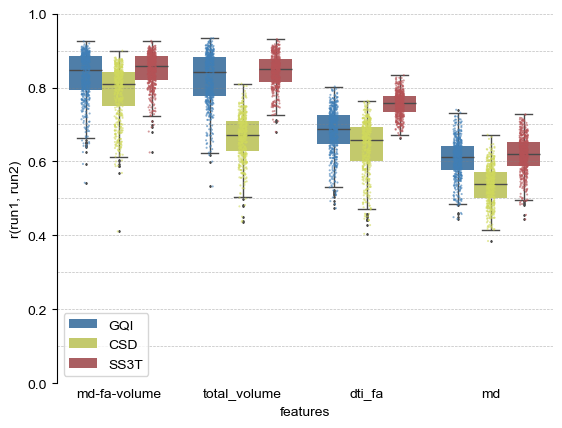

In [ ]:
# Plot
# Set colors and font
my_palette = sns.color_palette(
    [(64/255, 127/255, 183/255), (208/255, 217/255, 92/255), (182/255, 82/255, 86/255)])
sns.set_palette(my_palette)
mpl.rcParams["font.family"] = "Arial"

bp = sns.boxplot(df_corrs, x="features", y="r(run1, run2)", hue="reconstruction", boxprops={
                 "edgecolor": "none"}, flierprops={"marker": "d"}, fliersize=1)
sns.stripplot(df_corrs, x="features", y="r(run1, run2)", hue="reconstruction",
              dodge=True, legend=False, alpha=0.6, edgecolor="black", size=1.5)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

bp.set_ylim(0, 1)
plt.legend(loc='lower left')
plt.tick_params(axis='x', which='both', length=0)
plt.gca().spines['left'].set_visible(True)
for y in np.arange(0, 1.1, 0.1):
    plt.axhline(y=y, color="gray", linestyle="--", linewidth=0.5, alpha=0.5)
    
plt.savefig(f"{SAVE_ROOT}/{SAVE_NAME}")
plt.show()